In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm

/home/divyam/hackerearth/projects/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#Read the input data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Training image shape (55000, 784)
Training labels shape (55000, 10)
Shape of an image (1, 784)


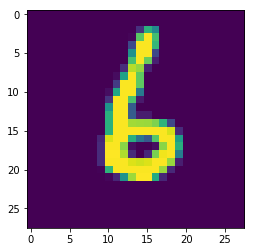

In [3]:
#Explore the data
sample_image = mnist.train.next_batch(1)[0]
print("Training image shape", mnist.train.images.shape)
print("Training labels shape", mnist.train.labels.shape)
print("Shape of an image", sample_image.shape)
sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image)

In [4]:
image_size = 28
labels_size = 10
learning_rate = 0.05
steps_number = 1000
batch_size = 100

In [5]:
# Placeholder is a value that we input when we ask TensorFlow to run a computation.
x = tf.placeholder(tf.float32, shape = [None,784])
y_ = tf.placeholder(tf.float32, shape = [None, 10])

In [6]:
# Functions for weights
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Function for bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution with stride = 1 and padding = 0
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

# Function for max pooling over 2*2 blocks
def max_pooling_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [7]:
# The architecture is similar to https://www.tensorflow.org/get_started/mnist/pros

# Input layer where single input image shape is (1,784)
x_image = tf.reshape(x, [-1,28,28,1])

# Convolution layer 1 - 32 x 5 x 5 
# Conv -> BatchNorm -> Relu -> Max_pool
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = conv2d(x_image, W_conv1) + b_conv1
y1 = tf.nn.relu(tf.layers.batch_normalization(x_conv1))
x_pool1 = max_pooling_2x2(y1)

# Conv layer 2 - 64 x 5 x 5
# Conv -> BatchNorm -> Relu -> Max_pool
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = conv2d(x_pool1, W_conv2) + b_conv2
y2 = tf.nn.relu(tf.layers.batch_normalization(x_conv2))
x_pool2 = max_pooling_2x2(y2)

# Flatten 
x_flat = tf.reshape(x_pool2, [-1, 7 * 7 * 64])

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024]) # max pooling reduced image to 7x7
b_fc1 = bias_variable([1024])
x_fc1 = tf.nn.relu(tf.layers.batch_normalization(tf.matmul(x_flat, W_fc1) + b_fc1))

# Dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

In [8]:
# Probabilities output from model
y = tf.nn.softmax(y_conv)

# Loss and Adam optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [9]:
# Test accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [11]:
# Train model
for i in tqdm(range(1000)):
    batch = mnist.train.next_batch(100)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("Epoch %d, training accuracy %g"%(i, train_accuracy))

    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, training accuracy 0.07


 20%|██        | 200/1000 [02:22<09:31,  1.40it/s]

Epoch 200, training accuracy 0.88


 40%|████      | 400/1000 [04:42<07:04,  1.41it/s]

Epoch 400, training accuracy 0.91


 60%|██████    | 600/1000 [07:54<05:16,  1.26it/s]

Epoch 600, training accuracy 0.95


 80%|████████  | 800/1000 [10:22<02:35,  1.28it/s]

Epoch 800, training accuracy 0.98


100%|██████████| 1000/1000 [12:55<00:00,  1.29it/s]


In [12]:
print(train_accuracy)
print((mnist.test.labels[:,2]))
#Save model
saver = tf.train.Saver()
saver.save(sess, "./classifier")

0.98
[ 0.  1.  0. ...,  0.  0.  0.]


'./classifier'

In [13]:
# Fetch 10 2's images
index_mask = np.where(mnist.test.labels[:, 2])[0]
print(index_mask)
subset_mask = np.random.choice(index_mask, 10)
print(subset_mask)

[   1   35   38 ..., 9980 9985 9995]
[ 980 8810 6321 8253 7163 9995 5272 6123 4260 7909]


In [14]:
# Display the labels of the selected images
original_images = mnist.test.images[subset_mask]
original_labels = mnist.test.labels[subset_mask]
original_labels

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [15]:
# Predict the model on the selected 10 2's samples
prediction = tf.argmax(y,1)
prediction_val = prediction.eval(feed_dict={x: original_images, keep_prob: 1.0}, session=sess)
print("predictions", prediction_val)
probabilities = y
probabilities_val = probabilities.eval(feed_dict={x: original_images, keep_prob: 1.0}, session=sess)
print ("probabilities", probabilities_val)

predictions [2 2 2 2 2 2 2 2 2 2]
probabilities [[  9.95959999e-06   1.08491186e-04   9.99706089e-01   6.21399086e-05
    5.57010799e-06   2.54786710e-06   6.44368847e-05   6.45166665e-06
    2.83060708e-05   5.98757651e-06]
 [  3.84693578e-07   1.23574796e-06   9.99990463e-01   5.02045441e-06
    5.04333002e-08   1.01335562e-08   9.64718510e-08   1.56562328e-06
    1.08618235e-06   3.17489679e-08]
 [  1.62354667e-07   2.78594676e-08   9.99998450e-01   6.03595993e-07
    4.86613372e-09   5.91751703e-10   5.62751779e-07   9.40936076e-08
    4.08400389e-08   2.51385615e-08]
 [  1.42668039e-04   6.52702365e-05   9.88692760e-01   1.50448328e-03
    7.19349273e-03   7.87782119e-06   9.41965191e-05   1.37351034e-03
    3.91234353e-04   5.34575433e-04]
 [  4.01252828e-06   1.29469190e-05   9.98051882e-01   3.63744075e-05
    4.81476036e-07   4.09673419e-07   6.38612960e-07   1.87748135e-03
    1.40831162e-05   1.77837990e-06]
 [  1.64998923e-07   3.80326696e-07   9.99991298e-01   3.91188405e-

Correct label 2
Predicted label: 2
Confidence: 0.999706


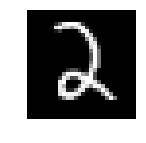

Correct label 2
Predicted label: 2
Confidence: 0.99999


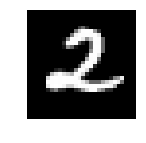

Correct label 2
Predicted label: 2
Confidence: 0.999998


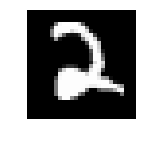

Correct label 2
Predicted label: 2
Confidence: 0.988693


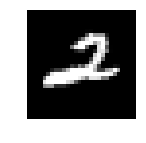

Correct label 2
Predicted label: 2
Confidence: 0.998052


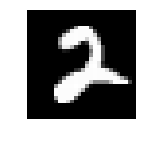

Correct label 2
Predicted label: 2
Confidence: 0.999991


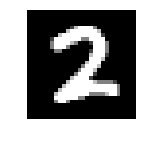

Correct label 2
Predicted label: 2
Confidence: 0.999977


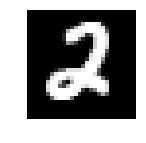

Correct label 2
Predicted label: 2
Confidence: 0.999996


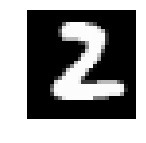

Correct label 2
Predicted label: 2
Confidence: 0.99295


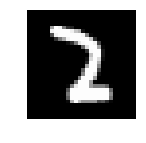

Correct label 2
Predicted label: 2
Confidence: 0.993624


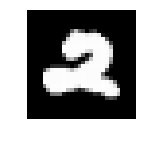

In [16]:
# Show the original images, correct, predicted label and confidence
for i in range(0, 10):
    print('Correct label', np.argmax(original_labels[i]))
    print('Predicted label:', prediction_val[i])
    print('Confidence:', np.max(probabilities_val[i]))
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(original_images[i].reshape([28, 28]),cmap = "gray")
    plt.show()

In [17]:
# Set the target label as 6
target_number = 6
target_labels = np.zeros(original_labels.shape)
target_labels[:, target_number] = 1

In [18]:
target_labels

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])

In [19]:
img_gradient = tf.gradients(cross_entropy, x)[0]

In [20]:
step_size = 0.5 #The amount to wiggle towards the gradient of target class.
steps = 10

In [21]:
#Targeted attack using Fast gradient sign method inspired from http://blog.ycombinator.com/how-adversarial-attacks-work/
# and http://karpathy.github.io/2015/03/30/breaking-convnets/
adversarial_img = original_images.copy()
for i in range(0, steps):
    gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
    #Update using value of gradient
    adversarial_img = adversarial_img - step_size * gradient
    prediction = tf.argmax(y,1)
    prediction_val = prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print("predictions", prediction_val)
    probabilities = y
    probabilities_val = probabilities.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print('Confidence 2:', probabilities_val[:, 2])
    print('Confidence 6:', probabilities_val[:, 6])

predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: [ 0.99817228  0.9999429   0.99998415  0.96527618  0.99375474  0.99996448
  0.99988294  0.99997246  0.97816467  0.9658851 ]
Confidence 6: [  9.57073993e-04   2.63057404e-06   1.10485480e-05   7.40761985e-04
   7.08008929e-06   1.07875401e-07   2.24455425e-06   1.30250555e-06
   1.20158102e-05   2.60757119e-03]
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: [ 0.98008841  0.99957615  0.99976188  0.89551318  0.9808256   0.99984884
  0.99940324  0.99979383  0.92620164  0.85679823]
Confidence 6: [  1.63573176e-02   8.10919228e-05   2.16041226e-04   6.01334311e-03
   8.54372556e-05   1.73322906e-06   4.65918565e-05   3.25475412e-05
   2.39301109e-04   2.97996588e-02]
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: [ 0.8519398   0.99645799  0.99734443  0.78262007  0.9597944   0.99940848
  0.99735153  0.99859053  0.83263677  0.62517703]
Confidence 6: [  1.37518376e-01   1.79526117e-03   2.55733193e-03   3.04192286e-02
   6.25863264e-04   2.001842

In [22]:
step_size = 0.02
steps = 10

In [23]:
adversarial_img = original_images.copy()
adv_img_hist = list()
prob2_hist = list()
prob6_hist = list()
for i in range(0, steps):
    gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
    # Update using sign of gradient and decreasing the step size
    adversarial_img = adversarial_img - step_size * np.sign(gradient)
    adv_img_hist.append(adversarial_img)
    prediction = tf.argmax(y,1)
    prediction_val = prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print("predictions", prediction_val)
    probabilities = y
    probabilities_val = probabilities.eval(feed_dict = {x: adversarial_img, keep_prob: 1.0}, session=sess)
    print('Confidence 2:', probabilities_val[:, 2])
    print('Confidence 6:', probabilities_val[:, 6])
prob2_hist.append(probabilities_val[:,2])
prob6_hist.append(probabilities_val[:,6])

predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: [ 0.99850178  0.99995542  0.99998677  0.96532702  0.99349135  0.99996483
  0.99989212  0.99997807  0.97948968  0.97023678]
Confidence 6: [  7.56708672e-04   1.52585812e-06   9.22730487e-06   7.49816129e-04
   7.25056043e-06   1.27019874e-07   1.61636763e-06   9.24627273e-07
   8.46084458e-06   2.13595340e-03]
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: [ 0.9867112   0.99974805  0.99984503  0.88273764  0.97971922  0.99985313
  0.99949217  0.99983644  0.9311974   0.87618339]
Confidence 6: [  1.07669914e-02   3.33004500e-05   1.38080475e-04   7.36348471e-03
   7.89412661e-05   2.35540597e-06   2.95757982e-05   2.16501921e-05
   1.51666172e-04   2.55298950e-02]
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: [ 0.87390345  0.99837458  0.99792504  0.73838425  0.93449736  0.9992888
  0.99754387  0.99886107  0.83644515  0.60820538]
Confidence 6: [  1.16723903e-01   5.89118456e-04   2.00599595e-03   4.39718664e-02
   7.96154956e-04   3.5966157

In [24]:
print("Probability of 2 in selected samples ",prob2_hist)
print("Probability of 6 in selected samples ",prob6_hist)

Probability of 2 in selected samples  [array([  3.25946130e-05,   1.39165460e-03,   3.21743923e-04,
         1.23969000e-03,   3.45435552e-03,   6.97328756e-03,
         1.39670330e-03,   9.96103161e-04,   1.06643781e-03,
         1.39624550e-04], dtype=float32)]
Probability of 6 in selected samples  [array([ 0.99993145,  0.99734759,  0.99961972,  0.99690163,  0.99296629,
        0.98609924,  0.9978168 ,  0.99785221,  0.99410194,  0.99955958], dtype=float32)]


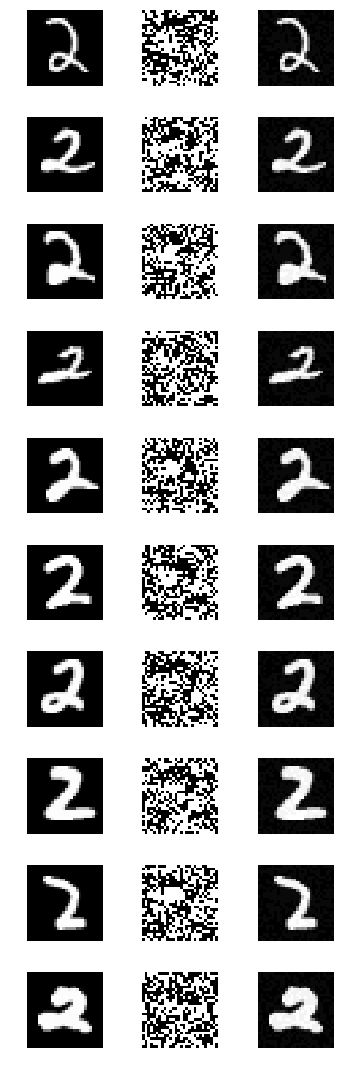

In [25]:
# Generate the image of 10 samples with original_image, delta and adversarial image
f, axarr = plt.subplots(10, 3, figsize=(5,15))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250
for i in range(10):
    axarr[i,0].set_axis_off()
    axarr[i,1].set_axis_off()
    axarr[i,2].set_axis_off()
    axarr[i,0].imshow(original_images[i].reshape([28, 28]), cmap = "gray")
    axarr[i,1].imshow((adv_img_hist[0][i] - original_images[i]).reshape([28, 28]), cmap = "gray")
    axarr[i,2].imshow((adv_img_hist[0][i]).reshape([28, 28]), cmap="gray")
    
plt.tight_layout()
plt.show()
f.savefig("result.png")